In [1]:
import swat

### Connect to server

In [2]:
s = swat.CAS("<CAS-HOST>", <CAS-PORT>)

### Load ONNX model

ONNX Model from https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/tiny-yolov3

In [3]:
onnxfile = "tiny-yolov3-11.onnx"
# read onnx
s.loadactionset('aStore')
with open(onnxfile,'rb') as file:
    blob = file.read()

NOTE: Added action set 'aStore'.


### Check ONNX

In [4]:
blob_ = swat.blob(blob)
s.aStore.check(onnx=blob_)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.NOTE: It is a valid ONNX model



+ Elapsed: 0.627s, user: 0.0585s, sys: 0.0186s, mem: 0.715mb

### Describe ONNX

In [5]:
res = s.aStore.describe(onnx=blob_)
print(res)

[AStore.Tab.Description]

 Basic Information
 
               Attribute       Value
 0            IR Version           6
 1         Model Version           0
 2                Domain        onnx
 3            Doc String            
 4         Producer Name  keras2onnx
 5      Producer Version       1.6.0
 6   Operator Set Domain            
 7  Operator Set Version          11

[AStore.Tab.InputValueInfo]

 Input Information
 
           Name  Length ValueType         Shape ElementType
 0      input_1     NaN    Tensor  (., 3, ., .)       FLOAT
 1  image_shape     NaN    Tensor        (., 2)       FLOAT

[AStore.Tab.OutputValueInfo]

 Output Information
 
                 Name  Length ValueType       Shape ElementType
 0    yolonms_layer_1     NaN    Tensor   (1, ., 4)       FLOAT
 1  yolonms_layer_1:1     NaN    Tensor  (1, 80, .)       FLOAT
 2  yolonms_layer_1:2     NaN    Tensor   (1, ., 3)       INT32

+ Elapsed: 0.613s, user: 0.0331s, sys: 0.0481s, mem: 1.88mb


### Load Images

In [6]:
# load images
s.loadactionset('image')

s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='data',
                  path='/path/to/data',
                  subdirectories=True)
s.image.loadimages(
    path='images',
    caslib='data',
    decode=True,
    addColumns=["CHANNELCOUNT", "CHANNELTYPE", "HEIGHT", "WIDTH"],
    casout=dict(name='imagesOrig', replication=0, replace=True),
)

NOTE: Added action set 'image'.
NOTE: Cloud Analytic Services added the caslib 'data'.
NOTE: Loaded 10 images from /path/to/data/images into Cloud Analytic Services table imagesOrig.


,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(sasuser),imagesOrig,10,12,"CASTable('imagesOrig', caslib='CASUSERHDFS(mac..."


## Process Images

In [7]:
# process images with SAS
encodedImage = True
inputColorOrder = 'RGB'
#{'options': {'functiontype': 'CONVERT_COLOR', 'type': 'BGR2RGB'}}
s.image.processimages(
    table='imagesOrig',
    steps=[
           {'step':{
               'stepType':'resize',
               'type':'LETTERBOX',
               'width': 416,
               'height': 416,
               'paddingmethod': 'CONSTANT',
               'b': 128,
               'g': 128,
               'r': 128
           }}
       ],
    decode=not encodedImage,
    copyvars=['_height_','_width_'],
    casout=dict(name='imagesResized',replace=True)
)

NOTE: The table IMAGESORIG contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesResized.


,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(sasuser),imagesResized,10,7,"CASTable('imagesResized', caslib='CASUSERHDFS(..."


### Save ONNX to rstore

YOLOv3 is a model that we specifically support. Because of this, the post-processing can all be completed using SAS.   
Description of some of the parameters:  
* `maxObjects`: the maximum number of objects to be detected in an image  
* `labels`: list of labels used in training the ONNX model  
* `modelType`: type of ONNX model, we currently only specifically support YOLOv2 and YOLOv3  

In [8]:
# saveas rstore
classList = [
"person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
"fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
"elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
"skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
"wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
"broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
"diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
"toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

s.aStore.saveas(
           table="imagesResized",
           rstore=dict(name="yolov3store", replace=True),
           onnx=blob_,
           inputs=[dict(vars=["_image_"],shape=[1,3,416,416],varbinaryType="UINT8", 
                        inputShapeOrder='NHWC', inputColorOrder='BGR',
                        modelShapeOrder='NCHW', modelColorOrder='RGB',
                        preprocess='NORMALIZE', normFactor=255,decoded=not encodedImage),
                   dict(vars=["_height_","_width_"],shape=[1,2])],
           modelType='YOLOV3',
           labels = classList,
           maxObjects=6
           )

NOTE: 35535515 bytes were written to the table "yolov3store" in the caslib "CASUSERHDFS(sasuser)".


+ Elapsed: 2.03s, user: 0.622s, sys: 0.461s, mem: 106mb

### Score image data with generated rstore

In [9]:
s.aStore.score(rstore="yolov3store", 
               table="imagesResized", 
               out=dict(name="imagesout1",replace=True), 
               copyvars=("_path_","_id_")
              )

[OutputCasTables]

                 casLib        Name  Rows  Columns  \
 0  CASUSERHDFS(sasuser)  imagesout1    10       39   
 
                                             casTable  
 0  CASTable('imagesout1', caslib='CASUSERHDFS(mac...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.045238  0.070112
 1  Creating the State  0.534900  0.829020
 2             Scoring  0.064281  0.099626
 3               Total  0.645221  1.000000

+ Elapsed: 0.684s, user: 7.04s, sys: 0.692s, mem: 193mb

In [10]:
# Add results to CASTable object
cas_results = s.CASTable("imagesout1")

### Post Process

In [11]:
# Function: extract bounding boxes from scored CASTable
# Input:
#    intable: input scored CASTable (output from aStore.score action)
#    outtable: name of CASTable to store results in
#    imageTable: name of CASTable that the original (non-resized) images are stored in
def get_bounding_boxes(intable,outtable,imageTable="imagesOrig"):
    ### SAS Processing
    s.loadactionset('fedsql')
    query_string = "create table " + outtable + " {options replace=true} as \
               select a._image_, a._dimension_, a._resolution_, a._imageformat_, a._id_,\
                      a._size_, a._path_, a._type_, \
                      b._object0_x as _object0_x, \
                      b._object0_width as _object0_width, \
                      b._object0_y as _object0_y, \
                      b._object0_height as _object0_height, \
                      b._object1_x as _object1_x, \
                      b._object1_width as _object1_width, \
                      b._object1_y as _object1_y, \
                      b._object1_height as _object1_height, \
                      b._object2_x as _object2_x, \
                      b._object2_width as _object2_width, \
                      b._object2_y as _object2_y, \
                      b._object2_height as _object2_height, \
                      b._object3_x as _object3_x, \
                      b._object3_width as _object3_width, \
                      b._object3_y as _object3_y, \
                      b._object3_height as _object3_height, \
                      b._object4_x as _object4_x, \
                      b._object4_width as _object4_width, \
                      b._object4_y as _object4_y, \
                      b._object4_height as _object4_height, \
                      b._object5_x as _object5_x, \
                      b._object5_width as _object5_width, \
                      b._object5_y as _object5_y, \
                      b._object5_height as _object5_height, \
                      b._object0_ as _object0_, \
                      b._object1_ as _object1_, \
                      b._object2_ as _object2_, \
                      b._object3_ as _object3_, \
                      b._object4_ as _object4_, \
                      b._object5_ as _object5_, \
                      b._nobjects_ as _nobjects_ \
               from " + imageTable + " as a, " + intable + " as b \
               where a._id_ = b._id_"
    s.fedsql.execdirect(query=query_string)

In [12]:
# Get bounding boxes, scaled
get_bounding_boxes("imagesout1","imagesDetected")

NOTE: Added action set 'fedsql'.
NOTE: Table IMAGESDETECTED was created in caslib CASUSERHDFS(sasuser) with 10 rows returned.


In [13]:
# Apply bounding box data to images
s.image.extractDetectedObjects(
    casOut={'name':'imagesBoxed', 'replace':True},
    table={'name':'imagesDetected'},
    maxObjects=6
)

NOTE: The table IMAGESDETECTED contains decoded images.
NOTE: 8 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesBoxed.


,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(sasuser),imagesBoxed,8,5,"CASTable('imagesBoxed', caslib='CASUSERHDFS(ma..."


In [14]:
# Create a CASTable object for the boxed images, view contents of table
imagesBoxed = s.CASTable('imagesBoxed')
imagesBoxed.head()

,_image_,_size_,_path_,_type_,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,314937,/path/to/data/images/image7.jpg,jpg,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,517942,/path/to/data/images/image0.jpg,jpg,2
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,500671,/path/to/data/images/image10.jpg,jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,574470,/path/to/data/images/image16.jpg,jpg,5
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,535804,/path/to/data/images/image3.jpg,jpg,8


### Display results

NOTE: The table IMAGESBOXED contains encoded images.


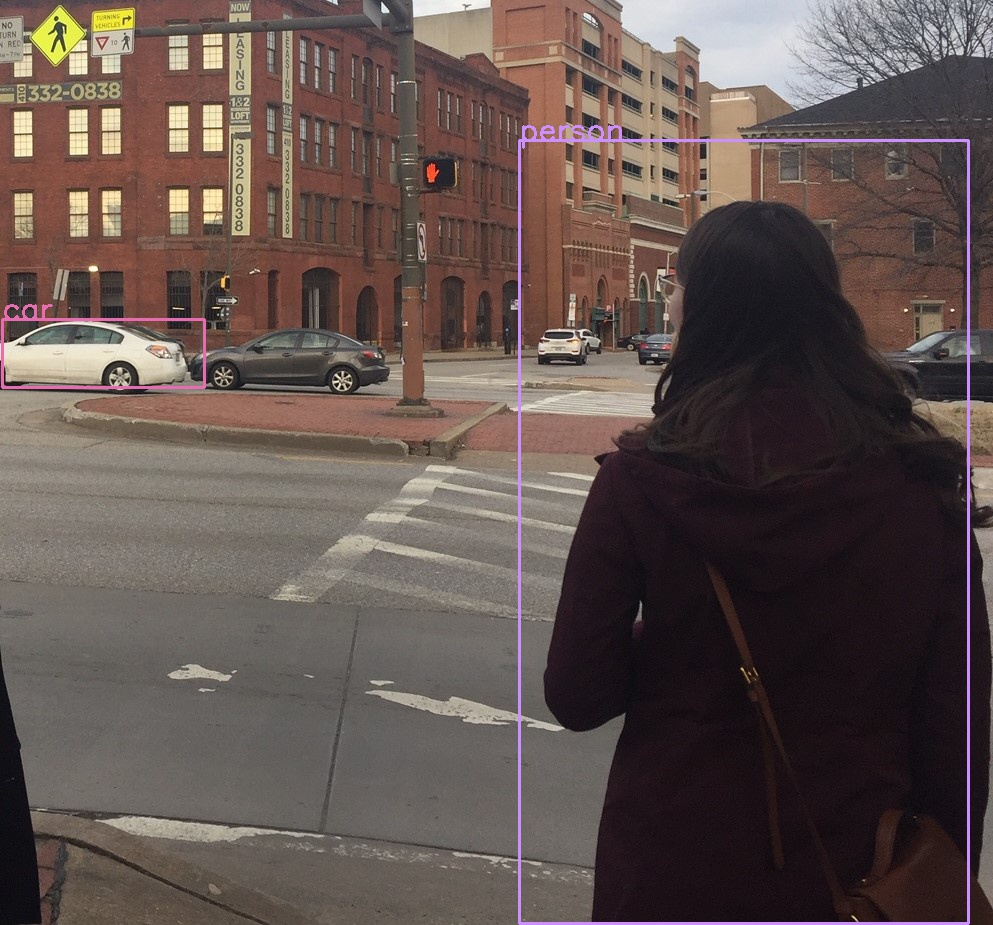

In [15]:
for img in imagesBoxed.fetchImages().Images['Image'][0:1]:
    display(img)